In [ ]:
"""
DEC training for In-Possession phase + feature-group ablation study.

Adds:
- Five semantic feature groups (G1-G5)
- Single-group removal ablations (train DEC from scratch per ablation)
- Metrics: NMI / ARI vs. full model, cluster centroid drift, team-level stability
"""

import json
import random
from itertools import permutations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score




from scipy.spatial.distance import cdist

def compute_indices(X: np.ndarray, labels: np.ndarray):
    """Compute internal indices used to build AC1/AC2: Iwcss, Isep, Idistcc, Idens."""
    labels = np.asarray(labels)
    uniq = np.unique(labels)
    n_clusters = len(uniq)

    centers = []
    for c in uniq:
        pts = X[labels == c]
        if len(pts) == 0:
            centers.append(np.zeros(X.shape[1], dtype=float))
        else:
            centers.append(pts.mean(axis=0))
    centers = np.asarray(centers)

    # Iwcss: within-cluster sum of squared distances to the corresponding center
    Iwcss = 0.0
    for i, c in enumerate(uniq):
        pts = X[labels == c]
        if len(pts) == 0:
            continue
        Iwcss += float(np.sum((pts - centers[i]) ** 2))

    # Isep: mean pairwise distance between centers (includes diagonal, consistent with your reference)
    Isep = float(np.mean(cdist(centers, centers))) if n_clusters > 0 else 0.0

    # Idistcc and Idens: mean distance-to-center and its std, averaged over valid clusters
    valid_dists, valid_dens = [], []
    for i, c in enumerate(uniq):
        pts = X[labels == c]
        if len(pts) < 2:
            continue
        d = np.linalg.norm(pts - centers[i], axis=1)
        valid_dists.append(float(np.mean(d)))
        valid_dens.append(float(np.std(d)))

    Idistcc = float(np.mean(valid_dists)) if valid_dists else 0.0
    Idens   = float(np.mean(valid_dens)) if valid_dens else 0.0
    return Iwcss, Isep, Idistcc, Idens

def minmax_normalize(val: float, min_val: float, max_val: float, larger_is_better: bool) -> float:
    """Min-max normalize to [0,1]; invert if larger_is_better=False."""
    if np.isclose(max_val - min_val, 0):
        return 1.0
    score = (val - min_val) / (max_val - min_val)
    return float(score) if larger_is_better else float(1 - score)
# ----------------------------
# Data
# ----------------------------
final_df = pd.read_csv("../../create_datasets/final_final_possesion_df.csv")
final_df.set_index("uniqueTeamId", inplace=True)
final_df.fillna(0, inplace=True)

# Keep feature list (column order matters for ablation)
ALL_FEATURES = list(final_df.columns)


# ----------------------------
# DEC model
# ----------------------------
class Encoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int = 10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
        )

    def forward(self, x):
        return self.model(x)


class Decoder(nn.Module):
    def __init__(self, latent_dim: int, output_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )

    def forward(self, z):
        return self.model(z)


class AutoEncoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int = 10):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


class DEC(nn.Module):
    def __init__(self, encoder: nn.Module, cluster_centers: torch.Tensor):
        super().__init__()
        self.encoder = encoder
        self.clusters = nn.Parameter(cluster_centers)

    def forward(self, x):
        z = self.encoder(x)
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.clusters) ** 2, dim=2))
        q = q / torch.sum(q, dim=1, keepdim=True)
        return q


def target_distribution(q: torch.Tensor) -> torch.Tensor:
    weight = q ** 2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()


# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# ----------------------------
# Training utilities
# ----------------------------
def train_dec_from_scratch(
    X: np.ndarray,
    k: int = 4,
    latent_dim: int = 10,
    pretrain_epochs: int = 3000,
    dec_epochs: int = 3000,
    lr: float = 1e-3,
    seed: int = 42,
):
    """Train AE -> init KMeans in latent -> DEC refinement. Returns labels + latent centers + latent embeddings."""
    set_seed(seed)

    X_tensor = torch.tensor(X, dtype=torch.float32)

    input_dim = X.shape[1]
    ae = AutoEncoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ae.parameters(), lr=lr)

    # AE pretrain
    print("AE pretrain starts...")
    for i in range(pretrain_epochs):
        optimizer.zero_grad()
        output = ae(X_tensor)
        loss = criterion(output, X_tensor)
        loss.backward()
        optimizer.step()
        if i%500 == 0:
            print(f"Epoch: {i}")

    # Init clusters with KMeans on latent z
    z = ae.encoder(X_tensor).detach().cpu().numpy()
    kmeans = KMeans(n_clusters=k, random_state=seed).fit(z)
    init_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)

    dec = DEC(ae.encoder, init_centers.clone())
    dec_optimizer = optim.Adam(dec.parameters(), lr=lr)

    # DEC refinement
    print("DEC refinement starts...")
    for i in range(dec_epochs):
        q = dec(X_tensor)
        p = target_distribution(q.detach())
        kl = torch.nn.functional.kl_div(q.log(), p, reduction="batchmean")
        dec_optimizer.zero_grad()
        kl.backward()
        dec_optimizer.step()
        if i%500 == 0:
            print(f"Epoch: {i}")

    with torch.no_grad():
        z_final = dec.encoder(X_tensor).detach().cpu().numpy()
        q_final = dec(X_tensor).detach().cpu().numpy()
        labels = np.argmax(q_final, axis=1)
        centers = dec.clusters.detach().cpu().numpy()

    return labels, centers, z_final


def align_centers_by_min_sum_distance(cent_full: np.ndarray, cent_alt: np.ndarray):
    """Align alt centers to full centers via brute-force permutation (OK for small k like 4)."""
    k = cent_full.shape[0]
    best_perm = None
    best_cost = 1e18
    for perm in permutations(range(k)):
        cost = float(np.sum(np.linalg.norm(cent_full - cent_alt[list(perm)], axis=1)))
        if cost < best_cost:
            best_cost = cost
            best_perm = perm
    return np.array(best_perm), best_cost / k  # average per-cluster drift


def majority_label_per_team(index_unique_team_id: pd.Index, labels: np.ndarray) -> pd.Series:
    """Team-level label via majority voting over matches. Expects index 'teamId---matchId'."""
    tmp = pd.DataFrame({
        "uniqueTeamId": index_unique_team_id.astype(str).values,
        "label": labels
    })
    tmp["teamId"] = tmp["uniqueTeamId"].str.split("---").str[0].astype(int)

    # Mode (majority). If tie, pandas mode returns multiple; take first for determinism.
    maj = tmp.groupby("teamId")["label"].agg(lambda x: x.mode().iloc[0])
    return maj


In [2]:
# ----------------------------
# Feature-group definitions (G1-G5)
# ----------------------------
FEATURE_GROUPS = {
    # G1 — Passing Volume & Network Structure
    "G1_PassingVolume_Network": [
        "Total_Passes",
        "Connectivity",
    ],
    # G2 — Passing Motifs & Combinational Patterns
    "G2_PassingMotifs": [
        "ABAB", "ABCA", "ABCB", "ABCD",
    ],
    # G3 — Passing Directionality (Global & Spatial)
    "G3_PassingDirectionality_GlobalSpatial": [
        "Backward Pass Ratio", "Forward Pass Ratio", "Side Pass Ratio",
        "Backward Pass_Zone_1 Ratio", "Backward Pass_Zone_2 Ratio", "Backward Pass_Zone_3 Ratio",
        "Forward Pass_Zone_1 Ratio", "Forward Pass_Zone_2 Ratio", "Forward Pass_Zone_3 Ratio",
        "Side Pass_Zone_1 Ratio", "Side Pass_Zone_2 Ratio", "Side Pass_Zone_3 Ratio",
    ],
    # G4 — Spatial Passing Distribution & Risk Profile
    "G4_SpatialPassRiskProfile": [
        "High_pass_Ratio_Total", "Low_pass_Ratio_Total",
        "High_pass_Ratio_Zone1", "Low_pass_Ratio_Zone1",
        "High_pass_Ratio_Zone2", "Low_pass_Ratio_Zone2",
        "High_pass_Ratio_Zone3", "Low_pass_Ratio_Zone3",
    ],
    # G5 — Shooting Volume & Shot Selection
    "G5_Shooting": [
        "Total Shots",
        "Far Shots Ratio",
        "Middle Distance Shots Ratio",
        "Near Shots Ratio",
    ],
}

# Sanity check: keep only groups that exist in the dataset (guards against typos / renamed columns)
for g, cols in list(FEATURE_GROUPS.items()):
    FEATURE_GROUPS[g] = [c for c in cols if c in ALL_FEATURES]

l = 0
for i in FEATURE_GROUPS:
    l += len(FEATURE_GROUPS[i])
l == len(ALL_FEATURES)

True

In [3]:
# ----------------------------
# Run: Full model + single-group removal ablations
# ----------------------------
k = 4
latent_dim = 10
seed = 42

# Scale (fit per experiment to avoid leakage across feature sets)
def fit_transform_scaled(df: pd.DataFrame) -> np.ndarray:
    scaler = StandardScaler()
    return scaler.fit_transform(df.values)

# Full model
X_full = fit_transform_scaled(final_df)
labels_full, centers_full, z_full = train_dec_from_scratch(
    X_full, k=k, latent_dim=latent_dim, seed=seed
)

sil_full = silhouette_score(z_full, labels_full)
team_full = majority_label_per_team(final_df.index, labels_full)

results = []
Iwcss_full, Isep_full, Idistcc_full, Idens_full = compute_indices(z_full, labels_full)
results.append({
    "Setting": "Full",
    "Removed_Group": "None",
    "NMI_vs_Full": 1.0,
    "ARI_vs_Full": 1.0,
    "CentroidDrift_vs_Full": 0.0,
    "TeamStability_vs_Full": 1.0,
    "Silhouette": sil_full,
    "Iwcss": Iwcss_full,
    "Isep": Isep_full,
    "Idistcc": Idistcc_full,
    "Idens": Idens_full,
    "Num_Features": final_df.shape[1],
})

AE pretrain starts...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
DEC refinement starts...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500


# Supervised Training

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
import lightgbm as lgb

In [5]:
# ----------------------------
# Surrogate supervised models for explainability (predict DEC clusters)
# ----------------------------
# We train high-fidelity multiclass classifiers to approximate DEC assignments.
# These models will later be used for feature importance / SHAP-based explanations.

X_sup = final_df.values
y_sup = labels_full

X_tr, X_te, y_tr, y_te = train_test_split(
    X_sup, y_sup, test_size=0.2, random_state=seed, stratify=y_sup
)


In [6]:
# XGBoost (multiclass)
xgb_clf = xgb.XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="multi:softprob",
    num_class=k,
    random_state=seed,
    n_jobs=-1,
    tree_method="hist",
)

xgb_clf.fit(
    X_tr, y_tr,
    eval_set=[(X_te, y_te)],
    verbose=False,
)

xgb_pred = xgb_clf.predict(X_te)
xgb_acc = float(accuracy_score(y_te, xgb_pred))
xgb_f1  = float(f1_score(y_te, xgb_pred, average="macro"))


In [7]:
# LightGBM (multiclass)
lgbm_clf = lgb.LGBMClassifier(
    n_estimators=1200,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multiclass",
    num_class=k,
    random_state=seed,
    n_jobs=-1,
)

lgbm_clf.fit(
    X_tr, y_tr,
    eval_set=[(X_te, y_te)],
    eval_metric="multi_logloss",
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)],
)

lgbm_pred = lgbm_clf.predict(X_te)
lgbm_acc = float(accuracy_score(y_te, lgbm_pred))
lgbm_f1  = float(f1_score(y_te, lgbm_pred, average="macro"))

In [8]:
lgbm_pred = lgbm_clf.predict(X_te)
lgbm_acc = float(accuracy_score(y_te, lgbm_pred))
lgbm_f1  = float(f1_score(y_te, lgbm_pred, average="macro"))

# Multinomial Logistic Regression (scaled)
# Useful as a simple, linear surrogate baseline.
logreg_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=5000,
        n_jobs=-1,
        random_state=seed,
    )),
])

logreg_clf.fit(X_tr, y_tr)
logreg_pred = logreg_clf.predict(X_te)
logreg_acc = float(accuracy_score(y_te, logreg_pred))
logreg_f1  = float(f1_score(y_te, logreg_pred, average="macro"))

In [9]:
perf_df = pd.DataFrame([
    {"Model": "XGBoost",  "Accuracy": xgb_acc,  "MacroF1": xgb_f1},
    {"Model": "LightGBM", "Accuracy": lgbm_acc, "MacroF1": lgbm_f1},
    {"Model": "Logistic Regression (Multinomial)", "Accuracy": logreg_acc, "MacroF1": logreg_f1},
]).sort_values(["MacroF1", "Accuracy"], ascending=False)

print("\nSurrogate model performance (test split):")
perf_df.to_csv("surrogate_model_performance.csv", index=False)
perf_df


Surrogate model performance (test split):


,Model,Accuracy,MacroF1
2,Logistic Regression (Multinomial),0.932969,0.931870
0,XGBoost,0.905609,0.904864
1,LightGBM,0.898769,0.897689


# Explainability

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score


# ----------------------------
# 1) Train multinomial LogReg surrogate
# ----------------------------
feature_names = list(final_df.columns)

X_sup = final_df.values
y_sup = labels_full.astype(int)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_sup, y_sup, test_size=0.2, random_state=seed, stratify=y_sup
)

logreg = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        solver="lbfgs",            # multinomial supported
        multi_class="auto",        # works as multinomial for multiclass
        max_iter=5000,
        random_state=seed
    ))
])

logreg.fit(X_tr, y_tr)

y_pred = logreg.predict(X_te)
acc = float(accuracy_score(y_te, y_pred))
mf1 = float(f1_score(y_te, y_pred, average="macro"))
print(f"LogReg surrogate (test): Accuracy={acc:.4f}, MacroF1={mf1:.4f}")

LogReg surrogate (test): Accuracy=0.9330, MacroF1=0.9319


SHAP values shape: (731, 30, 4)


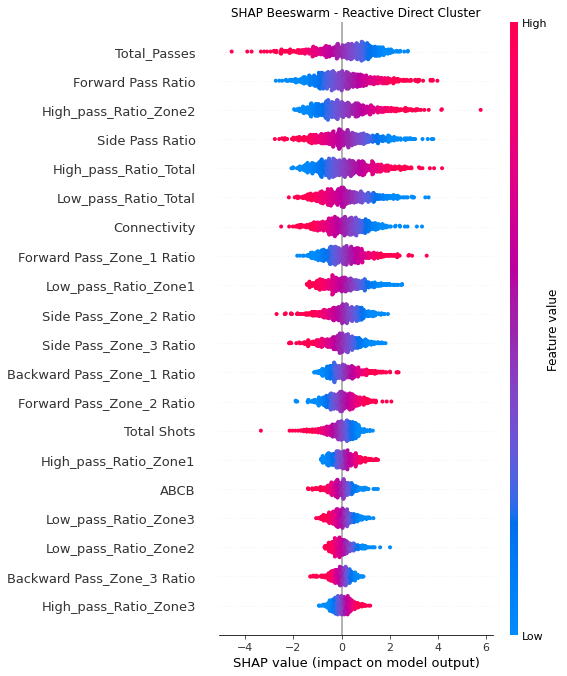

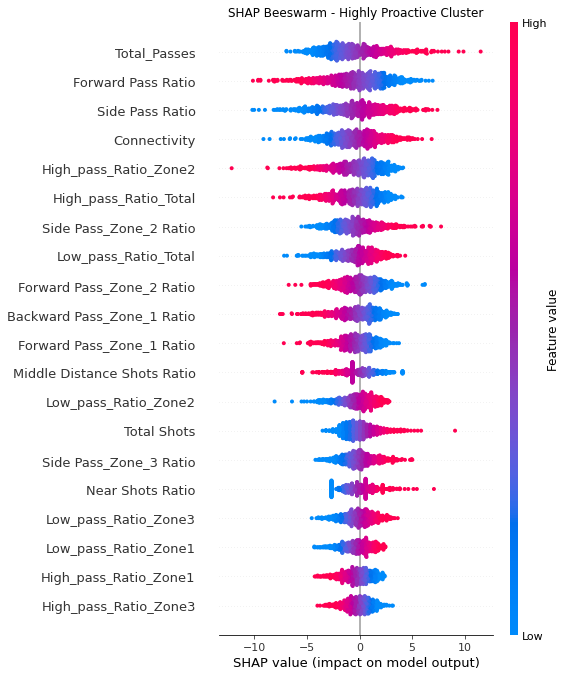

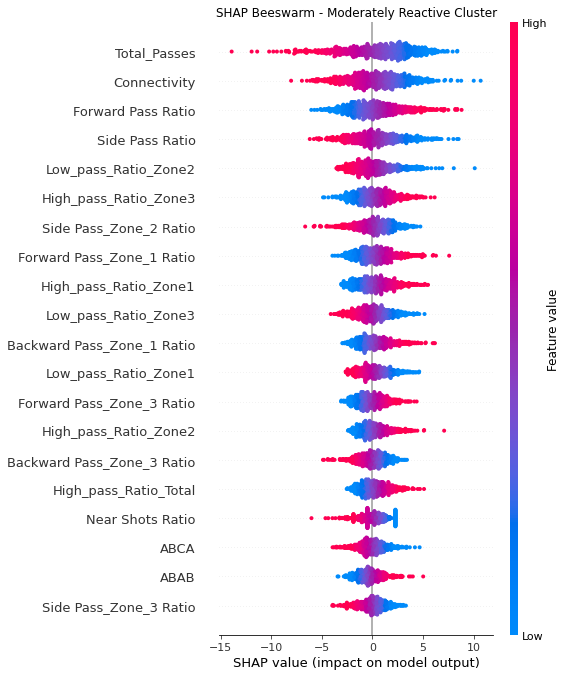

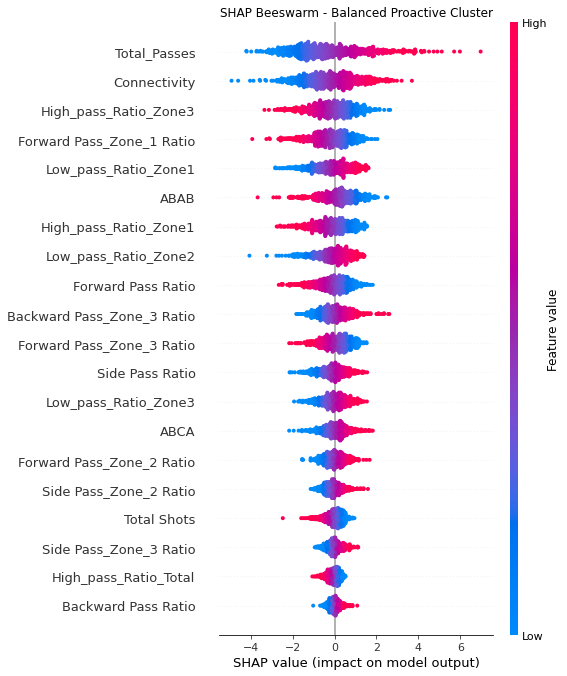

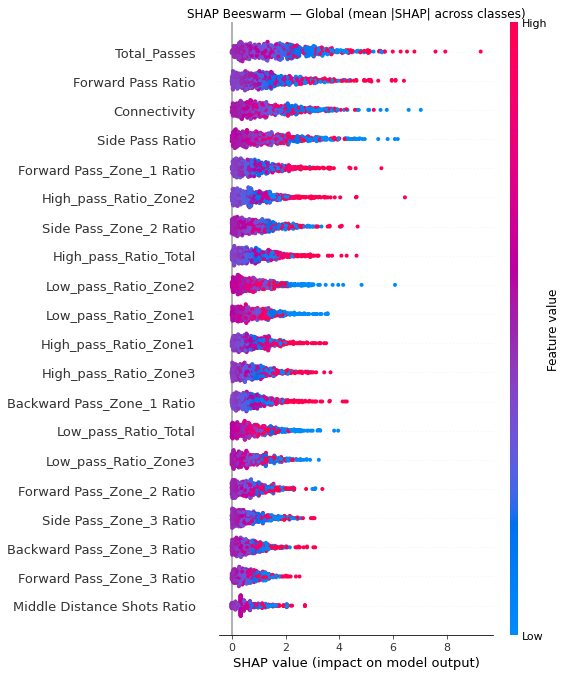

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# ----------------------------
# After you fit your pipeline "logreg" as you already do
# ----------------------------
scaler = logreg.named_steps["scaler"]
clf = logreg.named_steps["clf"]
classes = clf.classes_
feature_names = list(final_df.columns)

# Transform train/test to the standardized space the classifier actually sees
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

# Background set (keep it reasonably small for speed)
# For LinearExplainer you can often use 100-1000 rows
bg_size = min(500, X_tr_scaled.shape[0])
rng = np.random.default_rng(seed)
bg_idx = rng.choice(X_tr_scaled.shape[0], size=bg_size, replace=False)
X_bg = X_tr_scaled[bg_idx]

# ----------------------------
# 1) SHAP LinearExplainer for multinomial logistic regression
# ----------------------------
explainer = shap.LinearExplainer(
    model=clf,
    masker=X_bg,                # background in the same space as the model input
    feature_names=feature_names
)

# This returns a SHAP Explanation object
# For multiclass, values typically have shape: (n_samples, n_features, n_classes)
shap_exp = explainer(X_te_scaled)

print("SHAP values shape:", shap_exp.values.shape)  # expect (N, F, C)

# ----------------------------
# 2) Beeswarm (summary) plot
#    Option A: one beeswarm per class (recommended for multiclass)
# ----------------------------
# Map your cluster IDs to names (your dict)
name_dict = {
    0:"Reactive Direct",
    1:"Highly Proactive",
    2:"Moderately Reactive",
    3:"Balanced Proactive"
}

# If SHAP returns (N, F, C), make one plot per class
for k, c in enumerate(classes):
    plt.figure()
    shap.summary_plot(
        shap_exp.values[:, :, k],
        features=X_te_scaled,
        feature_names=feature_names,
        show=False,
        plot_type="dot"   # beeswarm
    )
    plt.title(f"SHAP Beeswarm - {name_dict.get(int(c), str(c))} Cluster")
    plt.tight_layout()
    plt.savefig(f"shap_beeswarm_class_{int(c)}.png", dpi=300, bbox_inches="tight")
    plt.show()


shap_abs_mean = np.mean(np.abs(shap_exp.values), axis=2)  # (N, F)
plt.figure()
shap.summary_plot(
    shap_abs_mean,
    features=X_te_scaled,
    feature_names=feature_names,
    show=False,
    plot_type="dot"
)
plt.title("SHAP Beeswarm — Global (mean |SHAP| across classes)")
plt.tight_layout()
plt.savefig("shap_beeswarm_global_mean_abs_over_classes.png", dpi=300, bbox_inches="tight")
plt.show()
